<a href="https://colab.research.google.com/github/Jarnoesse/IA-AGN-with-ML/blob/main/classifier_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following part is the data analisys/dimensional reduction from mr. Pedro Ferreira's notebook

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, plot_confusion_matrix, classification_report, explained_variance_score

from pandas.plotting import scatter_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

import missingno as msno

plt.style.use('seaborn')


import os.path

**Adding colors**: We do this because this gives us the slope of a magnitude plot, so it's a really important aspect of this data and gives us a lot of useful information. Having it done without the non-visible colors before, we see a clear improvement on the dimensionality reduction plots when we add the IR and near-IR colors (W1-W2,J-KS,KS-W1)! [Pedro Ferreira]

In [15]:
table_des_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_DES_specZ_milliquas_basicFeatures.csv'
table_des_cat = Table.read(table_des_catalogue_URL)

des_df = table_des_cat.to_pandas()

table_ps_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_PS_specZ_milliquas_basicFeatures.csv'
table_ps_cat = Table.read(table_ps_catalogue_URL)

ps_df = table_ps_cat.to_pandas()

table_sm_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv'
table_sm_cat = Table.read(table_sm_catalogue_URL)

sm_df = table_sm_cat.to_pandas()

In [16]:
des_df['W1-W2'] = des_df['W1MAG']-des_df['W2MAG']
des_df['J-KS'] = des_df['J_VISTA']-des_df['KS_VISTA']
des_df['KS-W1'] = des_df['KS_VISTA']-des_df['W1MAG']
des_df['G-R'] = des_df['MAG_G']-des_df['MAG_R']
des_df['R-Z'] = des_df['MAG_R']-des_df['MAG_Z']
des_df['Z-J'] = des_df['MAG_Z']-des_df['J_VISTA']
des_df['G-RadioR'] = des_df['MAG_G']-des_df['flux_int']
des_df['W2-RadioR'] = des_df['W2MAG']-des_df['flux_int']

ps_df['W1-W2'] = ps_df['W1MAG']-ps_df['W2MAG']
ps_df['J-KS'] = ps_df['J_VISTA']-ps_df['KS_VISTA']
ps_df['KS-W1'] = ps_df['KS_VISTA']-ps_df['W1MAG']
ps_df['G-R'] = ps_df['MAG_G']-ps_df['MAG_R']
ps_df['R-Z'] = ps_df['MAG_R']-ps_df['MAG_Z']
ps_df['Z-J'] = ps_df['MAG_Z']-ps_df['J_VISTA']
ps_df['G-RadioR'] = ps_df['MAG_G']-ps_df['flux_int']
ps_df['W2-RadioR'] = ps_df['W2MAG']-ps_df['flux_int']

sm_df['W1-W2'] = sm_df['W1MAG']-sm_df['W2MAG']
sm_df['J-KS'] = sm_df['J_VISTA']-sm_df['KS_VISTA']
sm_df['KS-W1'] = sm_df['KS_VISTA']-sm_df['W1MAG']
sm_df['U-G'] = sm_df['MAG_U']-sm_df['MAG_G']
sm_df['G-R'] = sm_df['MAG_G']-sm_df['MAG_R']
sm_df['R-Z'] = sm_df['MAG_R']-sm_df['MAG_Z']
sm_df['Z-J'] = sm_df['MAG_Z']-sm_df['J_VISTA']
sm_df['G-RadioR'] = sm_df['MAG_G']-sm_df['flux_int']
sm_df['W2-RadioR'] = sm_df['W2MAG']-sm_df['flux_int']

**Working with the data catalogues**: from the above dataframe, we remove the features that won't contribute to the analysis, like the ones that just identify the objects. We also remove the class (star, agn, galaxy) and the redshift because we want to check afterwards if there is clusters on the reduced data plots that relate to each object's redshift and class.

In [17]:
des_sample = des_df.drop(['n_components','col0','catalogue_id','quality_level','SOURCEID_VISTA'], axis = 1)
des_sample = des_sample.dropna()  #sem os unclassified
desarray = des_sample.drop(['z_spec','spec_class'], axis=1).to_numpy()

ps_sample = ps_df.drop(['n_components','col0','catalogue_id','quality_level','SOURCEID_VISTA'], axis = 1)
ps_sample = ps_sample.dropna()  #sem os unclassified
psarray = ps_sample.drop(['z_spec','spec_class'], axis=1).to_numpy()

sm_sample = sm_df.drop(['n_components','col0','catalogue_id','quality_level','SOURCEID_VISTA'], axis = 1)
sm_sample = sm_sample.dropna()  #sem os unclassified
smarray = sm_sample.drop(['z_spec','spec_class'], axis=1).to_numpy()

So this is one of the dataframes on which we will do dimensionality reduction:

In [18]:
ps_sample

,flux_int,flux_peak,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR
0,14.271548,14.272466,14.449,14.211,14.706843,14.757310,0.000171,15.9414,15.4132,15.2604,15.0925,0.082,1,0.238000,-0.050467,0.308310,0.5282,0.3207,0.385657,1.669852,-0.060549
1,15.087712,15.005931,15.582,15.717,15.234133,14.885287,0.000171,16.1638,15.5859,15.3284,15.1686,0.062,1,-0.135000,0.348846,-0.696713,0.5779,0.4173,-0.065533,1.076088,0.629288
2,8.276081,8.479472,14.661,14.276,16.120893,15.419022,0.052478,16.6373,16.5356,16.6504,16.1415,0.391,1,0.385000,0.701871,0.758022,0.1017,0.3941,0.020607,8.361219,5.999919
3,12.600692,12.604439,19.226,19.309,19.790708,19.173853,0.499230,19.9939,20.2113,20.0435,19.7645,2.367,1,-0.083000,0.616855,-0.052147,-0.2174,0.4468,-0.026208,7.393208,6.708308
4,15.417818,15.128676,17.898,18.291,17.633600,17.159678,0.000171,19.7773,18.7711,18.3317,17.9279,0.271,1,-0.392999,0.473922,-0.738322,1.0062,0.8432,0.294300,4.359482,2.873182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71505,13.008310,13.038626,18.439,17.840,20.034221,18.905024,0.000010,21.2537,21.5828,20.9368,20.0989,0.195,1,0.598999,1.129197,0.466024,-0.3291,1.4839,0.064679,8.245390,4.831690
71506,13.113121,13.132223,16.787,16.525,17.724560,17.162191,0.999981,20.4939,19.5336,18.6965,18.3080,0.564,1,0.262000,0.562369,0.375191,0.9603,1.2256,0.583440,7.380779,3.411879
71507,11.578844,12.868261,17.047,16.629,18.276413,17.892172,0.000171,19.0971,19.1318,18.7885,18.4751,0.586,1,0.418000,0.384241,0.845172,-0.0347,0.6567,0.198687,7.518256,5.050156
71508,13.890164,13.856373,18.082,17.727,18.505855,18.459696,0.999657,19.0425,18.8057,18.9779,18.8010,0.963,1,0.355001,0.046159,0.377696,0.2368,0.0047,0.295145,5.152336,3.836835


Dropping unimportant (or higly correlatred labels)

In [19]:
des_df = des_df.drop(['col0','catalogue_id','flux_peak','quality_level','SOURCEID_VISTA','W1MAG','J_VISTA','KS_VISTA','MAG_G','MAG_R','MAG_I','MAG_Z'], axis = 1)
ps_df = ps_df.drop(['col0','catalogue_id','flux_peak','quality_level','SOURCEID_VISTA','W2MAG','J_VISTA','KS_VISTA','MAG_G','MAG_R','MAG_I','MAG_Z'], axis = 1)
sm_df = sm_df.drop(['col0','catalogue_id','flux_peak','quality_level','SOURCEID_VISTA','W1MAG','J_VISTA','KS_VISTA','MAG_U','MAG_G','MAG_R','MAG_I','MAG_Z'], axis = 1)

ML model with keras

In [20]:
from numpy import unique
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [23]:
ps_sample

,flux_int,flux_peak,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR
0,14.271548,14.272466,14.449,14.211,14.706843,14.757310,0.000171,15.9414,15.4132,15.2604,15.0925,0.082,1,0.238000,-0.050467,0.308310,0.5282,0.3207,0.385657,1.669852,-0.060549
1,15.087712,15.005931,15.582,15.717,15.234133,14.885287,0.000171,16.1638,15.5859,15.3284,15.1686,0.062,1,-0.135000,0.348846,-0.696713,0.5779,0.4173,-0.065533,1.076088,0.629288
2,8.276081,8.479472,14.661,14.276,16.120893,15.419022,0.052478,16.6373,16.5356,16.6504,16.1415,0.391,1,0.385000,0.701871,0.758022,0.1017,0.3941,0.020607,8.361219,5.999919
3,12.600692,12.604439,19.226,19.309,19.790708,19.173853,0.499230,19.9939,20.2113,20.0435,19.7645,2.367,1,-0.083000,0.616855,-0.052147,-0.2174,0.4468,-0.026208,7.393208,6.708308
4,15.417818,15.128676,17.898,18.291,17.633600,17.159678,0.000171,19.7773,18.7711,18.3317,17.9279,0.271,1,-0.392999,0.473922,-0.738322,1.0062,0.8432,0.294300,4.359482,2.873182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71505,13.008310,13.038626,18.439,17.840,20.034221,18.905024,0.000010,21.2537,21.5828,20.9368,20.0989,0.195,1,0.598999,1.129197,0.466024,-0.3291,1.4839,0.064679,8.245390,4.831690
71506,13.113121,13.132223,16.787,16.525,17.724560,17.162191,0.999981,20.4939,19.5336,18.6965,18.3080,0.564,1,0.262000,0.562369,0.375191,0.9603,1.2256,0.583440,7.380779,3.411879
71507,11.578844,12.868261,17.047,16.629,18.276413,17.892172,0.000171,19.0971,19.1318,18.7885,18.4751,0.586,1,0.418000,0.384241,0.845172,-0.0347,0.6567,0.198687,7.518256,5.050156
71508,13.890164,13.856373,18.082,17.727,18.505855,18.459696,0.999657,19.0425,18.8057,18.9779,18.8010,0.963,1,0.355001,0.046159,0.377696,0.2368,0.0047,0.295145,5.152336,3.836835


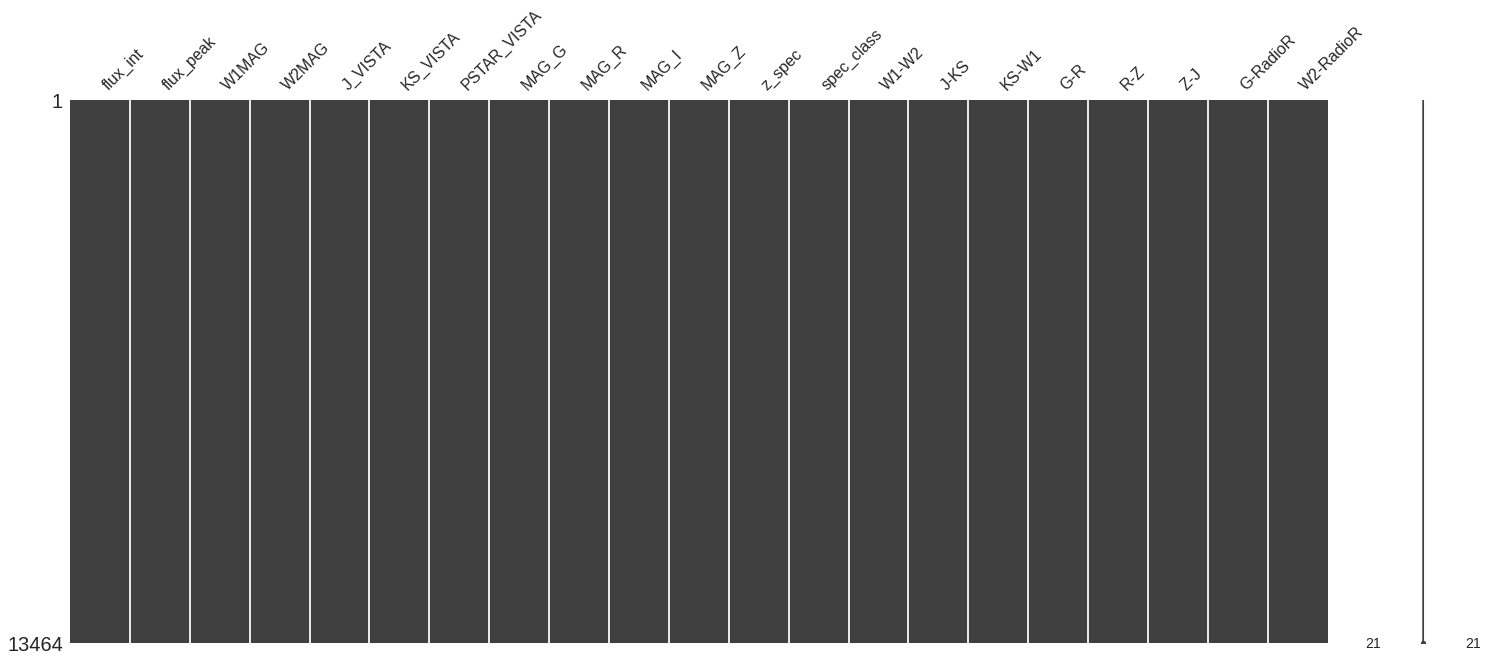

In [27]:
msno.matrix(ps_sample)

In [40]:
ps_sample

,flux_int,flux_peak,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR
0,14.271548,14.272466,14.449,14.211,14.706843,14.757310,0.000171,15.9414,15.4132,15.2604,15.0925,0.082,1,0.238000,-0.050467,0.308310,0.5282,0.3207,0.385657,1.669852,-0.060549
1,15.087712,15.005931,15.582,15.717,15.234133,14.885287,0.000171,16.1638,15.5859,15.3284,15.1686,0.062,1,-0.135000,0.348846,-0.696713,0.5779,0.4173,-0.065533,1.076088,0.629288
2,8.276081,8.479472,14.661,14.276,16.120893,15.419022,0.052478,16.6373,16.5356,16.6504,16.1415,0.391,1,0.385000,0.701871,0.758022,0.1017,0.3941,0.020607,8.361219,5.999919
3,12.600692,12.604439,19.226,19.309,19.790708,19.173853,0.499230,19.9939,20.2113,20.0435,19.7645,2.367,1,-0.083000,0.616855,-0.052147,-0.2174,0.4468,-0.026208,7.393208,6.708308
4,15.417818,15.128676,17.898,18.291,17.633600,17.159678,0.000171,19.7773,18.7711,18.3317,17.9279,0.271,1,-0.392999,0.473922,-0.738322,1.0062,0.8432,0.294300,4.359482,2.873182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71505,13.008310,13.038626,18.439,17.840,20.034221,18.905024,0.000010,21.2537,21.5828,20.9368,20.0989,0.195,1,0.598999,1.129197,0.466024,-0.3291,1.4839,0.064679,8.245390,4.831690
71506,13.113121,13.132223,16.787,16.525,17.724560,17.162191,0.999981,20.4939,19.5336,18.6965,18.3080,0.564,1,0.262000,0.562369,0.375191,0.9603,1.2256,0.583440,7.380779,3.411879
71507,11.578844,12.868261,17.047,16.629,18.276413,17.892172,0.000171,19.0971,19.1318,18.7885,18.4751,0.586,1,0.418000,0.384241,0.845172,-0.0347,0.6567,0.198687,7.518256,5.050156
71508,13.890164,13.856373,18.082,17.727,18.505855,18.459696,0.999657,19.0425,18.8057,18.9779,18.8010,0.963,1,0.355001,0.046159,0.377696,0.2368,0.0047,0.295145,5.152336,3.836835


creating the dataset from the features we want to use

In [43]:
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
dataset = ps_sample[attributes].values

checking the dataset

In [44]:
dataset

array([[14.27154833, 14.27246598, 14.449     , ...,  0.385657  ,
         1.66985167, -0.06054859],
       [15.08771213, 15.00593128, 15.58200037, ..., -0.065533  ,
         1.07608787,  0.62928813],
       [ 8.27608086,  8.47947176, 14.66099989, ...,  0.020607  ,
         8.36121914,  5.99991942],
       ...,
       [11.57884394, 12.86826077, 17.04699957, ...,  0.198687  ,
         7.51825606,  5.05015603],
       [13.89016448, 13.85637318, 18.08200037, ...,  0.295145  ,
         5.15233552,  3.83683505],
       [15.16600638, 15.04480463, 17.22600043, ...,  0.282338  ,
         4.17409362,  2.26399323]])

Creating the y arrays for classification and the regression, turning the y regression and the datasets into floats for better handling by Keras

In [73]:
y_class = ps_sample["spec_class"].values
y =ps_sample["z_spec"].values 
n_class = len(unique(y_class))
dataset, y, y_class = dataset.astype('float'), y.astype('float'),y_class.astype("int")

Calculating the feature number we want to pass to the Keras model

In [74]:
n_features = dataset.shape[1]

splitting train and test sets

In [75]:
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(dataset, y, y_class, test_size=0.33, random_state=1)

compiling the keras model

In [76]:
visible = Input(shape=(n_features,))
hidden1 = Dense(20, activation='relu', kernel_initializer='he_normal')(visible)
hidden2 = Dense(10, activation='relu', kernel_initializer='he_normal')(hidden1)

In [77]:
out_reg = Dense(1, activation='linear')(hidden2)

In [78]:
out_clas = Dense(n_class, activation='softmax')(hidden2)

In [79]:
model = Model(inputs=visible, outputs=[out_reg, out_clas])

In [80]:
model.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

fitting the model

In [81]:
model.fit(X_train, [y_train,y_train_class], epochs=150, batch_size=32, verbose=2)

Epoch 1/150
282/282 - 1s - loss: 2.5590 - dense_10_loss: 1.8339 - dense_11_loss: 0.7251
Epoch 2/150
282/282 - 0s - loss: 0.5899 - dense_10_loss: 0.1565 - dense_11_loss: 0.4333
Epoch 3/150
282/282 - 0s - loss: 0.4576 - dense_10_loss: 0.1248 - dense_11_loss: 0.3328
Epoch 4/150
282/282 - 0s - loss: 0.4283 - dense_10_loss: 0.1223 - dense_11_loss: 0.3060
Epoch 5/150
282/282 - 0s - loss: 0.4183 - dense_10_loss: 0.1207 - dense_11_loss: 0.2976
Epoch 6/150
282/282 - 0s - loss: 0.4118 - dense_10_loss: 0.1210 - dense_11_loss: 0.2908
Epoch 7/150
282/282 - 0s - loss: 0.4044 - dense_10_loss: 0.1186 - dense_11_loss: 0.2858
Epoch 8/150
282/282 - 0s - loss: 0.4010 - dense_10_loss: 0.1180 - dense_11_loss: 0.2829
Epoch 9/150
282/282 - 0s - loss: 0.3976 - dense_10_loss: 0.1171 - dense_11_loss: 0.2805
Epoch 10/150
282/282 - 0s - loss: 0.3954 - dense_10_loss: 0.1160 - dense_11_loss: 0.2793
Epoch 11/150
282/282 - 0s - loss: 0.3944 - dense_10_loss: 0.1154 - dense_11_loss: 0.2791
Epoch 12/150
282/282 - 0s - lo

In [82]:
yhat1, yhat2 = model.predict(X_test)

In [83]:
yhat1

array([[-0.06245512],
       [ 0.16570604],
       [ 1.1316738 ],
       ...,
       [ 0.32148397],
       [ 0.04790771],
       [ 0.14896417]], dtype=float32)

In [84]:
yhat2

array([[1.6529553e-03, 4.1595399e-02, 9.5675164e-01],
       [1.9619559e-04, 2.7458597e-02, 9.7234523e-01],
       [4.4329540e-06, 9.9437803e-01, 5.6175981e-03],
       ...,
       [6.6638151e-03, 1.9433549e-01, 7.9900074e-01],
       [1.9309693e-03, 6.2633139e-01, 3.7173757e-01],
       [3.7603243e-04, 3.0248847e-02, 9.6937513e-01]], dtype=float32)

In [85]:
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.108


In [86]:
yhat2 = argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Accuracy: %.3f' % acc)

Accuracy: 0.926
